# Plotting a stock's price chart with corporate action overlay

Sometimes, a picture is worth a thousand words.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

In [2]:
symbol <- "YESBANK"
startDt <- as.Date(Sys.Date() - 3*365) #3-year chart
endDt <- Sys.Date()

startDtNum <- as.numeric(format(startDt, '%Y%m%d'))
endDtNum <- as.numeric(format(endDt, '%Y%m%d'))

# examples: https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

#make sure that the data exists

equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol 
           & (SERIES == 'EQ' | SERIES == 'BE')) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()

equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(DATE_STAMP >= startDtNum & DATE_STAMP <= endDtNum 
           & SYMBOL == symbol) %>%
    summarize(MAX_DT = max(DATE_STAMP), MIN_DT = min(DATE_STAMP)) %>%
    print()


Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:   lazy query [?? x 2]
# Database: Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockViz]
  MAX_DT     MIN_DT    
  <date>     <date>    
1 2019-07-18 2016-07-19
# Source:   lazy query [?? x 2]
# Database: postgres [ro1@SWEDEN:5432/StockVizDyn]
    MAX_DT   MIN_DT
     <int>    <int>
1 20190718 20160719


In [3]:
# so the data exists in both so we can use the EodAdjustedTimeSeries

eodPxDf <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(DATE_STAMP >= startDtNum & DATE_STAMP <= endDtNum & SYMBOL == symbol) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(as.character(DATE_STAMP), format="%Y%m%d")) %>%
    select(TIME_STAMP, CLOSE) %>%
    arrange(TIME_STAMP) %>%
    as.data.frame()

print(head(eodPxDf))

  TIME_STAMP   CLOSE
1 2016-07-19 223.950
2 2016-07-20 225.775
3 2016-07-21 224.200
4 2016-07-22 224.600
5 2016-07-25 229.650
6 2016-07-26 233.025


In [4]:
corpDf <- equitiesIndiaNse$CorporateActions() %>%
    filter(EX_DATE >= startDt & EX_DATE <= endDt & SYMBOL == symbol & SERIES == 'EQ') %>%
    select(EX_DATE, PURPOSE) %>%
    arrange(EX_DATE) %>%
    collect() %>%
    as.data.frame()
    
print(head(corpDf))

     EX_DATE
1 2017-05-29
2 2017-09-21
3 2018-06-04
4 2019-06-03
                                                                         PURPOSE
1                            ANNUAL GENERAL MEETING/DIVIDEND - RS 12/- PER SHARE
2  FACE VALUE SPLIT (SUB-DIVISION) - FROM RS 10/- PER SHARE TO RS 2/- PER SHARE 
3                            ANNUAL GENERAL MEETING / DIVIDEND- RS 2.7 PER SHARE
4                              ANNUAL GENERAL MEETING/ DIVIDEND - RS 2 PER SHARE


In [5]:
startDate <- first(eodPxDf$TIME_STAMP)
endDate <- last(eodPxDf$TIME_STAMP)

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

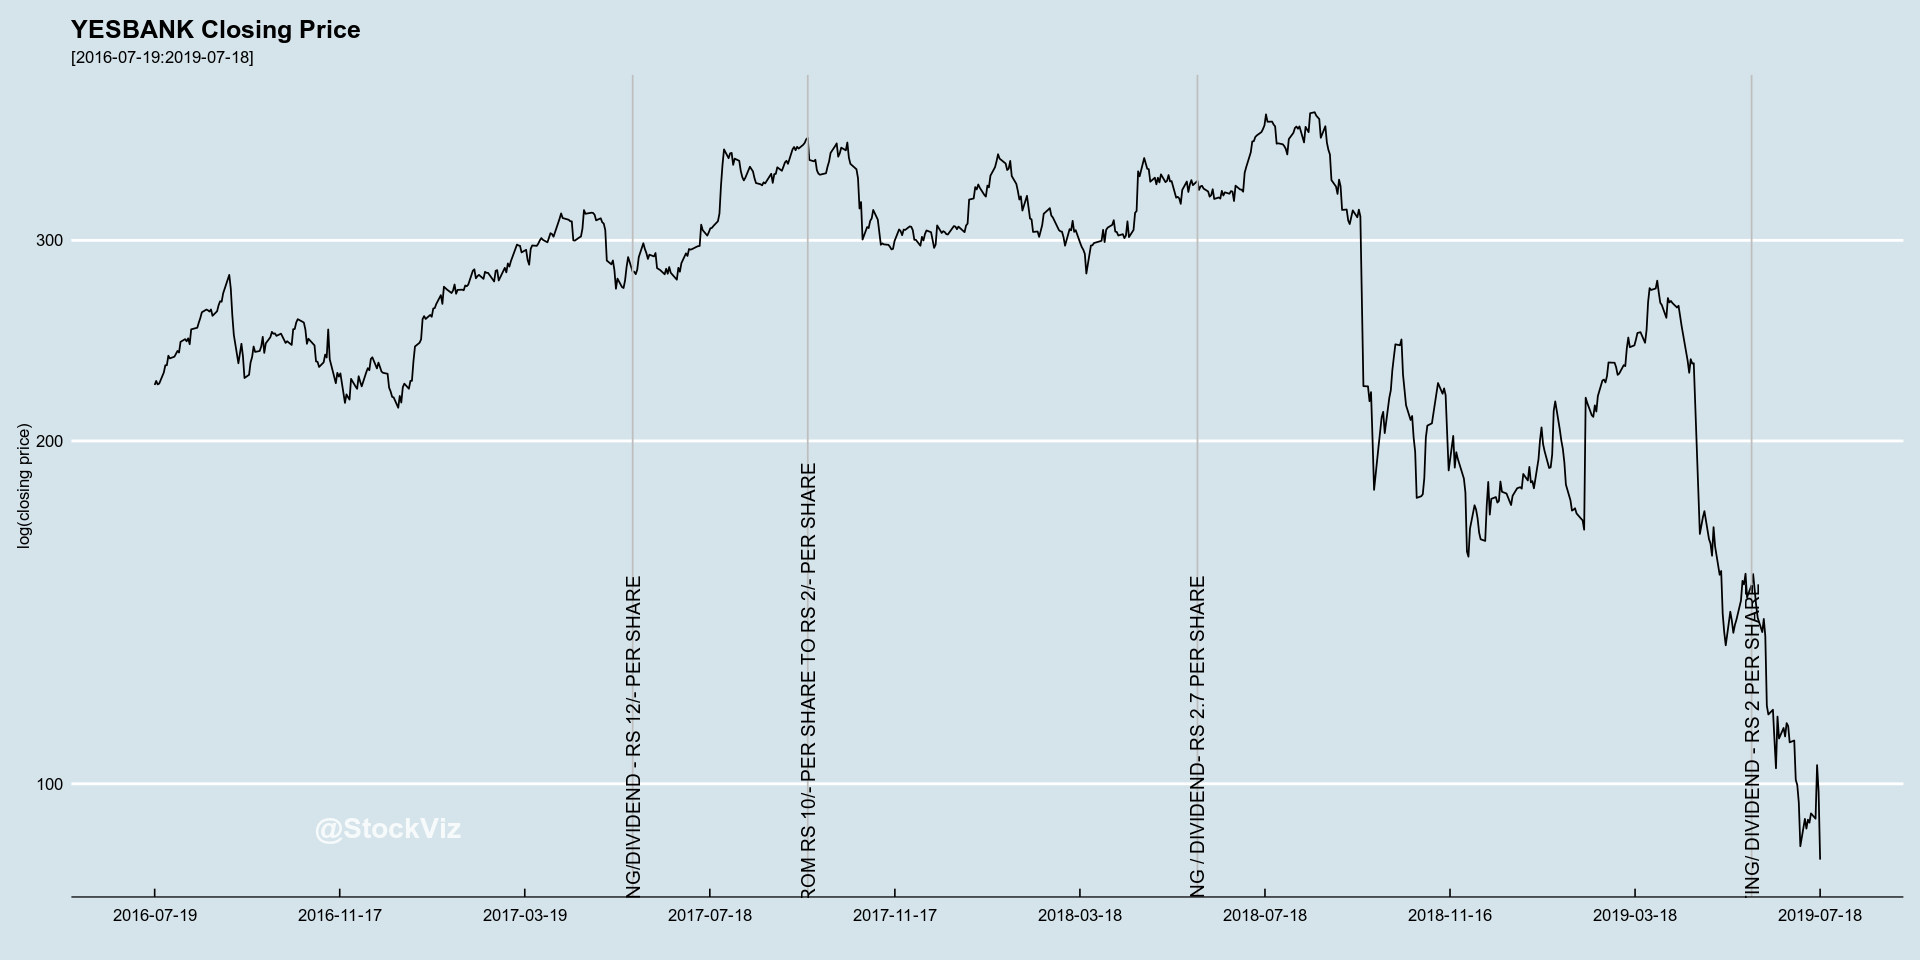

In [6]:
ggplot(eodPxDf, aes(x = TIME_STAMP, y = CLOSE)) + 
    theme_economist() +
    geom_line() + 
    geom_vline(xintercept = corpDf$EX_DATE, colour="grey") +
    annotate("text", x = corpDf$EX_DATE, y = min(eodPxDf$CLOSE, na.rm=T), label = corpDf$PURPOSE,
            col='black', cex = 4, angle = 90) +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(closing price)', fill='', color='',
         title=sprintf("%s Closing Price", symbol), 
         subtitle=sprintf("[%s:%s]", startDate, endDate)) +
    annotate("text", x=startDate, y=min(eodPxDf$CLOSE, na.rm=T), label = "@StockViz", 
             hjust=-1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)